In [24]:
!pip install kagglehub==0.3.3
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install keras-tuner -q

  Using cached kagglehub-0.3.3-py3-none-any.whl.metadata (22 kB)
Using cached kagglehub-0.3.3-py3-none-any.whl (42 kB)
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: '/opt/conda/lib/python3.11/site-packages/kagglehub'
Consider using the `--user` option or check the permissions.

ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: '/opt/conda/lib/python3.11/site-packages/kerastuner'
Consider using the `--user` option or check the permissions.



In [25]:
import sys
sys.path.append('/home/scxie/.local/lib/python3.11/site-packages')
import kagglehub
import os
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import keras_tuner
import logging
tf.random.set_seed(42) # set seed for reproducibility later in code
# Suppress cuDNN plugin registration warnings

In [26]:
# Download latest version of kaggle dataset
path = kagglehub.dataset_download("alistairking/recyclable-and-household-waste-classification")

In [27]:
# Get image paths and create lists to populate later
class_path = path + '/images' + '/images'
classes = os.listdir(class_path)
image_paths = []
labels = [] # Trash category associated with each image
d_r = [] # default (studio/standard) vs real world img


In [28]:
# Access image folders and populate lists with needed data
# Serena's shit
for i, label in enumerate(classes):
    class_dir = os.path.join(class_path, label)
    for subfolder in ['default', 'real_world']:
        subfolder_dir = os.path.join(class_dir, subfolder)
        image_names = os.listdir(subfolder_dir)
        
        for image_name in image_names:
            d_r.append(subfolder)
            image_paths.append(os.path.join(subfolder_dir, image_name))
            labels.append(label)

In [29]:
# Load all data into df
columnDict = {'image_path': image_paths, 'label': labels, 'default_vs_real_world': d_r}
df = pd.DataFrame(columnDict)
df.shape

(15000, 3)

## Clean Data

In [30]:
clean_df = df.copy()
clean_df.label.unique()
cat_dic = {
    'landfill' : ['clothing', 'disposable_plastic_cutlery', 'plastic_shopping_bags', 'plastic_trash_bags',\
                  'shoes', 'styrofoam_cups', 'styrofoam_food_containers', 'paper_cups', 'plastic_straws', 'plastic_cup_lids'],
    'recyclable' : ['aerosol_cans','aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'glass_beverage_bottles',\
                    'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'plastic_detergent_bottles',\
                    'plastic_food_containers','plastic_soda_bottles', 'plastic_water_bottles', 'steel_food_cans'],
    'compost' : ['coffee_grounds', 'eggshells', 'food_waste', 'tea_bags']
}

# Create a reverse lookup dictionary to map items to categories
item_to_category = {item: category for category, items in cat_dic.items() for item in items}

# Map the labels to respective categories using lookup dictionary
clean_df['category'] = df['label'].map(item_to_category)
clean_df.head()

,image_path,label,default_vs_real_world,category
0,/home/scxie/.cache/kagglehub/datasets/alistair...,disposable_plastic_cutlery,default,landfill
1,/home/scxie/.cache/kagglehub/datasets/alistair...,disposable_plastic_cutlery,default,landfill
2,/home/scxie/.cache/kagglehub/datasets/alistair...,disposable_plastic_cutlery,default,landfill
3,/home/scxie/.cache/kagglehub/datasets/alistair...,disposable_plastic_cutlery,default,landfill
4,/home/scxie/.cache/kagglehub/datasets/alistair...,disposable_plastic_cutlery,default,landfill


In [31]:
def subset(df, num):
    """
    Gets subset of dataframe.

    ARGS:
        df: dataframe 
        num(float): decimal representing what amt of original df you wanna use for subset (eg. .5 or .3)
    RETURNS:
        df: smaller df that's shuffled
    """
    return df.sample(frac=num, random_state=42).reset_index(drop=True)
    
# CHANGE frac TO 1 WHEN USING SUPER COMPUTER 
frac = 1 #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
tiny_df = subset(clean_df, frac)
tiny_df.shape

(15000, 4)

In [32]:
def train_val_test(df):
    """
    Split df into train, val, test. HARDCODED to 60% train, 20% val and 20% test btw
    """
    # Get rid of unnecessary columns HARDCODED
    df = df[['image_path', 'category']]
    # Split into train and temp (40% for validation + test)
    train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
    
    # Split temp into validation and test (10% each)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
    
    print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")
    return train_df, val_df, test_df

train_df, val_df, test_df = train_val_test(tiny_df)
train_df.head()

Train size: 9000, Validation size: 3000, Test size: 3000


,image_path,category
2269,/home/scxie/.cache/kagglehub/datasets/alistair...,recyclable
8020,/home/scxie/.cache/kagglehub/datasets/alistair...,compost
8165,/home/scxie/.cache/kagglehub/datasets/alistair...,recyclable
12124,/home/scxie/.cache/kagglehub/datasets/alistair...,landfill
9963,/home/scxie/.cache/kagglehub/datasets/alistair...,recyclable


### Convert to Image Generators

In [ ]:
def to_gen(df, shuffle=True):
    """
    Convert pandas df to tensorflow image generator.
    ARGS:
        df: pandas df
    RETURNS 
        gen: tensorflow dataset
    """
    #preprocess = tf.keras.applications.vgg16.preprocess_input # preprocessing function for CNN
    rescale=1./255
    target_size=(224,224) # set the size of the images
    color_mode='rgb' # set the type of image
    class_mode= 'categorical' # set the class mode
    batch_size=32  # set the batch size 
    gen=ImageDataGenerator(rescale=rescale).flow_from_dataframe(df, 
          x_col='image_path',
          y_col='category', target_size=target_size, color_mode=color_mode,
          class_mode=class_mode, batch_size=batch_size, shuffle=shuffle)
    return gen
pandas_dfs = [train_df, val_df, test_df]
train_batches, val_batches = [to_gen(df) for df in pandas_dfs[:-1]]
test_batches = to_gen(test_df, shuffle=False) # Don't shuffle test data for Conf Matrix

Found 9000 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.


#### Double check distribution of categories for each set

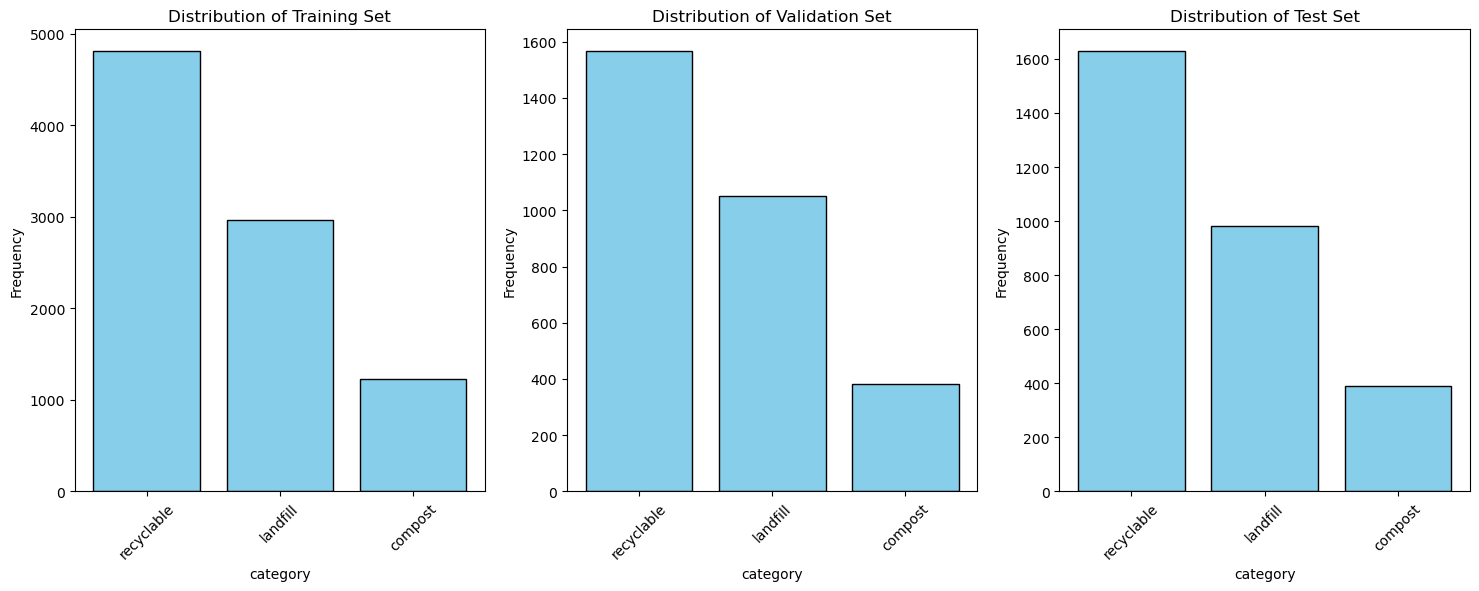

In [34]:
def df_hist():
    """
    Plots category distributions of train, valid, and test sets.
    """
    # Create a figure with 3 subplots (1 row, 3 columns)
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    column = 'category'
    names = ["Training Set", "Validation Set", "Test Set"]
    for i, df in enumerate(pandas_dfs):
        axs[i].bar(df[column].value_counts().index, df[column].value_counts().values, color='skyblue', edgecolor='black')
        axs[i].set_title(f'Distribution of {names[i]}')
        axs[i].set_xlabel(column)
        axs[i].set_ylabel('Frequency')
        axs[i].tick_params(axis='x', rotation=45)
df_hist()

## CNN: Train and Validation 

In [35]:
# generate batch of images and labels from training set
imgs, labels = next(train_batches)

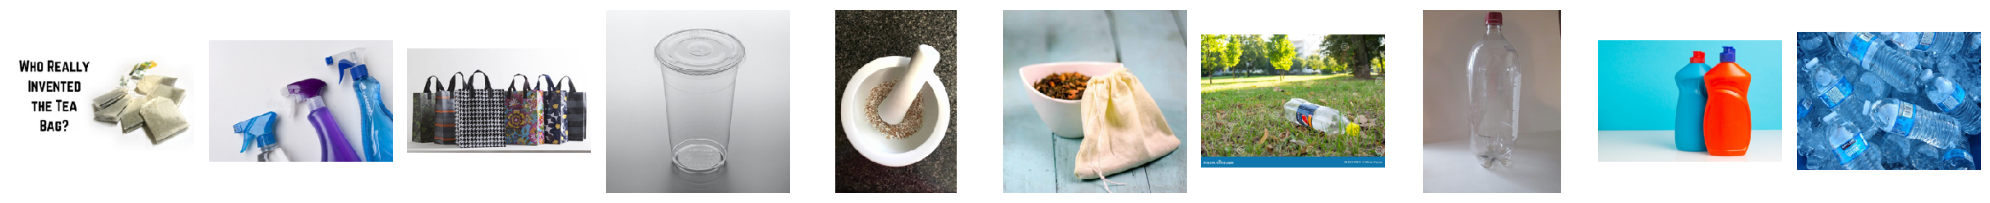

[0. 0. 1.]


In [36]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(imgs) # images look fucky because of the preprocessing function 
print(labels[-1]) # example of one hot encoding of categories

In [57]:
# Build CNN
model2 = Sequential([
    # Input Layer
    Input(shape=(224, 224, 3)),
    # Hidden Layer 1
    Conv2D(filters=12, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    #Dropout(0.25),
    # Hidden Layer 2
    Conv2D(filters=24, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    # Hidden Layer 3
    #Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    #MaxPool2D(pool_size=(2, 2), strides=2),
    Dropout(0.25),
    Flatten(),
    # Hidden Layer 3
    Dense(units=64, activation='relu'),
    Dropout(0.5),
    # Output Layer
    Dense(units=3, activation='softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 12)      336       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 112, 112, 12)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 24)      2616      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 56, 56, 24)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 56, 56, 24)        0         
                                                                 
 flatten_2 (Flatten)         (None, 75264)            

In [58]:
# SPECIFY EARLY STOPPAGE
def early_stop():
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=5,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True
    )
    return early_stopping
early_stopping=early_stop()

In [59]:
model2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
history = model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=val_batches,
    validation_steps=len(val_batches),
    epochs=12,
    verbose=1,
)

Epoch 1/12
282/282 [==============================] - 279s 986ms/step - loss: 1.0750 - accuracy: 0.5108 - val_loss: 0.9222 - val_accuracy: 0.5340
Epoch 2/12
282/282 [==============================] - 275s 973ms/step - loss: 0.9222 - accuracy: 0.5393 - val_loss: 0.8628 - val_accuracy: 0.5423
Epoch 3/12
282/282 [==============================] - 271s 961ms/step - loss: 0.8787 - accuracy: 0.5699 - val_loss: 0.8146 - val_accuracy: 0.5860
Epoch 4/12
282/282 [==============================] - 275s 974ms/step - loss: 0.8175 - accuracy: 0.6003 - val_loss: 0.7789 - val_accuracy: 0.6103
Epoch 5/12
282/282 [==============================] - 274s 970ms/step - loss: 0.7644 - accuracy: 0.6340 - val_loss: 0.7415 - val_accuracy: 0.6380
Epoch 6/12
282/282 [==============================] - 276s 979ms/step - loss: 0.7046 - accuracy: 0.6681 - val_loss: 0.7191 - val_accuracy: 0.6610
Epoch 7/12
282/282 [==============================] - 275s 975ms/step - loss: 0.6411 - accuracy: 0.7012 - val_loss: 0.7127 -

### Fitting Graph 
(Model used to generate fitting graph is overfit and should not be used for actual prediction)

In [60]:
# DO NOT RUN
history = model2.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=val_batches,
    validation_steps=len(val_batches),
    epochs=20,
    verbose=1,
)

Epoch 1/20
282/282 [==============================] - 247s 873ms/step - loss: 1.1467 - accuracy: 0.5082 - val_loss: 0.9030 - val_accuracy: 0.5240
Epoch 2/20
282/282 [==============================] - 247s 877ms/step - loss: 0.9119 - accuracy: 0.5392 - val_loss: 0.8406 - val_accuracy: 0.5747
Epoch 3/20
282/282 [==============================] - 249s 883ms/step - loss: 0.8410 - accuracy: 0.5797 - val_loss: 0.7879 - val_accuracy: 0.6057
Epoch 4/20
282/282 [==============================] - 250s 887ms/step - loss: 0.7684 - accuracy: 0.6102 - val_loss: 0.7361 - val_accuracy: 0.6357
Epoch 5/20
282/282 [==============================] - 268s 950ms/step - loss: 0.7108 - accuracy: 0.6412 - val_loss: 0.7009 - val_accuracy: 0.7003
Epoch 6/20
282/282 [==============================] - 253s 896ms/step - loss: 0.6409 - accuracy: 0.6856 - val_loss: 0.6917 - val_accuracy: 0.7143
Epoch 7/20
282/282 [==============================] - 273s 967ms/step - loss: 0.5809 - accuracy: 0.7192 - val_loss: 0.6639 -

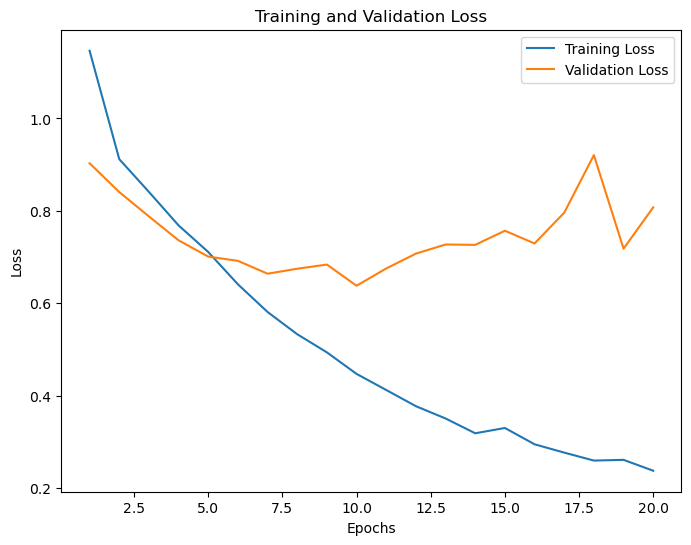

In [61]:
# Extract the training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')

# Adding labels and title
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plot
plt.show()

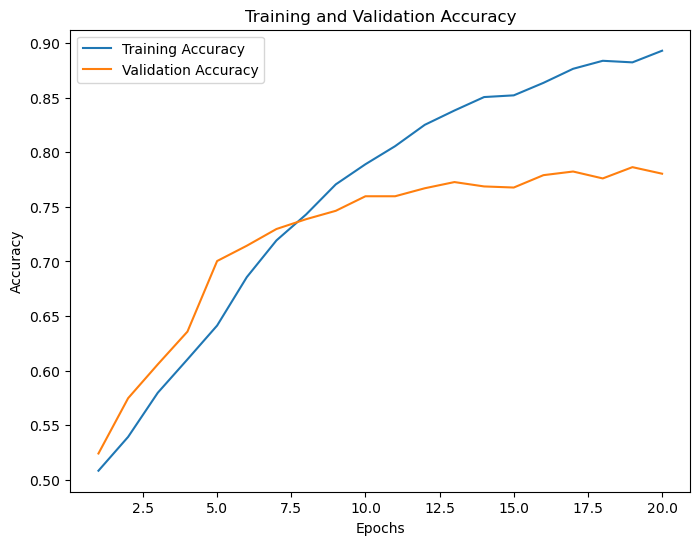

In [62]:
# Extract the training and validation loss from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')

# Adding labels and title
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plot
plt.show()

## Predict Ideal Model on Test

In [ ]:
# Take a look at the test images
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [42]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [43]:
# Show predictions rounded
np.round(predictions) 

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

### Confusion Matrix
*** The confusion matrix below is incorrect because of the labels of the test set were shuffled. See confusion matrix attached in github for an accurate confusion matrix

In [44]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [46]:
# CODE COPIED FROM SCI-KIT LEARN
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [47]:
test_batches.class_indices

{'compost': 0, 'landfill': 1, 'recyclable': 2}

Confusion matrix, without normalization
[[ 34 138 219]
 [ 85 346 550]
 [138 515 975]]


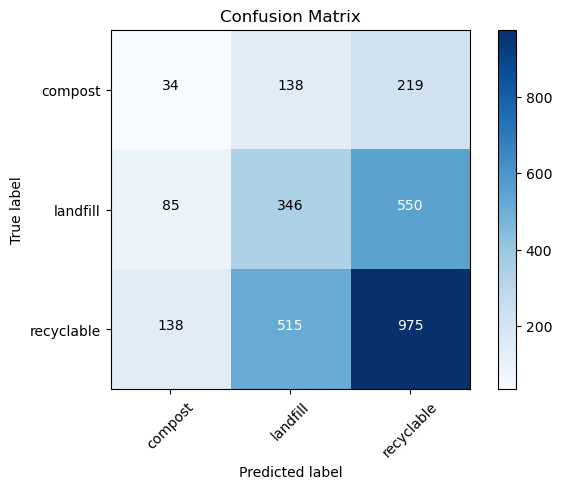

In [48]:
cm_plot_labels = ['compost','landfill', 'recyclable']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

### Accuracy and Loss of final model

In [49]:
# Assuming test_batches is a generator like ImageDataGenerator for your test data
loss, accuracy = model.evaluate(test_batches, verbose=1)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy * 100:.2f}%')

94/94 [==============================] - 19s 205ms/step - loss: 0.7327 - accuracy: 0.7500
Test Loss: 0.732672929763794
Test Accuracy: 75.00%


### Tuning Hyperparams

In [ ]:
def buildHPModel(hp):
    model = Sequential([
        # Input Layer
        Input(shape=(224, 224, 3)),
        # Hidden Layer 1
        Conv2D(filters=hp.Int('filters', min_value=12, max_value = 36, step=12), kernel_size=(3, 3), 
            activation=hp.Choice('activation', values=['relu', 'tanh']), padding = 'same'),
        MaxPool2D(pool_size=(2, 2), strides=2),
        #Dropout(0.25),
        # Hidden Layer 2
        Conv2D(filters=hp.Int('filters', min_value=24, max_value=78, step=12), kernel_size=(3, 3),
            activation=hp.Choice('activation', values=['relu', 'tanh']), padding = 'same'),
        MaxPool2D(pool_size=(2, 2), strides=2),
        #Dropout(0.25),
        Flatten(),
        # Output Layer
        Dense(units=3, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.01])),
        loss='categorical_crossentropy', metrics=['accuracy'])
    return model

hp = keras_tuner.HyperParameters()
# Define tuner
tuner = keras_tuner.GridSearch(
    hypermodel=buildHPModel,
    objective="val_accuracy",
    max_trials=72, # 2*2*3*3*2
    seed=42,
    executions_per_trial=1,
    hyperparameters=hp,
    tune_new_entries=True,
    allow_new_entries=True,
    #max_retries_per_trial=0,
    max_consecutive_failed_trials=5,
)
tuner.search_space_summary()

In [25]:
tuner.search(train_batches, validation_data=val_batches, epochs=20, verbose=1, callbacks=[early_stopping])

In [26]:
models = tuner.get_best_models(num_models=1)
models[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 12)      336       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 12)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 12)      1308      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 12)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 37632)             0         
                                                                 
 dense (Dense)               (None, 3)                 1